In [48]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(font_scale=1.5, style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (16, 12)

In [49]:
orange_raster_dir = "/home/dat/Workspace/Thesis/orange_predictor/data/rasters_csv/2017-11-17"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Orange/orange.csv"

## Load data and calculate indices

In [3]:
df = pd.read_csv(csv_file)
df["raster_path"] = [os.path.join(orange_raster_dir, row["ID"]+".npy") for id, row in df.iterrows()]
# Remove improperly cropped images
df = df[df["ID"] != "26D"]
df = df[df["ID"] != "35E"]
df = df[df["ID"] != "42C"]
df = df[df["ID"] != "44F"]
df.describe()

,Chlorophyll,NDVI,WP
count,72.000000,72.000000,70.000000
mean,50.560828,0.821028,-8.615771
std,10.030131,0.040890,1.727900
min,25.453333,0.694674,-14.097143
25%,42.921333,0.794305,-9.437000
50%,51.537667,0.831986,-8.701571
75%,58.085333,0.852459,-7.409500
max,68.360000,0.871767,-5.288571


In [4]:
EPSILON = 1e-10

def NDVI(R, NIR):
    return (NIR - R) / (NIR + R + EPSILON)

def RedEdge(R, RE):
    return RE / (R + EPSILON)

def EVI(B, R, NIR):
    return 2.5 * (NIR - R) / (NIR + EPSILON) + 6 * R - 7.5 * B + 1 

def MCARI(G, R, RE):
    return (RE - R) - 0.23 * (RE - G) * RE / (R + EPSILON)

def GNDVI(G, NIR):
    return (NIR - G) / (NIR + G + EPSILON)

In [5]:
ndvi, rededge, evi, mcari, gndvi, channel_vals = [], [], [], [], [], []
for id, row in df.iterrows():
    raster = np.load(row["raster_path"])
    # Crop border to only get tree in image
    raster = raster[10:-10, 10:-10]
    b, g, r, re, nir = np.mean(raster, axis=(0, 1))
    ndvi.append(NDVI(r, nir))
    rededge.append(RedEdge(r, re))
    evi.append(EVI(b, r, nir))
    mcari.append(MCARI(g, r, re))
    gndvi.append(GNDVI(g, nir))
    # channel_vals.append([b, g, r, re, nir])
    channel_vals.append([b, g, r])
    
df["UAV_NDVI"] = ndvi
df["RedEdge"] = rededge
df["EVI"] = evi
df["MCARI"] = mcari
df["GNDVI"] = gndvi
df["channel_vals"] = channel_vals

In [6]:
df.head()

,ID,Chlorophyll,NDVI,WP,raster_path,UAV_NDVI,RedEdge,EVI,MCARI,GNDVI,channel_vals
0,14E,45.130,0.790624,-8.498,/home/dat/Workspace/Thesis/orange_predictor/da...,0.371546,2.528736,1.978037,0.188396,0.140478,"[0.19873777695021003, 0.3054054230382147, 0.18..."
1,57B,53.224,0.822390,-7.544,/home/dat/Workspace/Thesis/orange_predictor/da...,0.324222,2.621469,1.758810,0.159224,0.139444,"[0.19854930796955372, 0.2525093503433348, 0.17..."
2,22E,63.525,0.866294,-8.279,/home/dat/Workspace/Thesis/orange_predictor/da...,0.411300,2.673086,1.961145,0.181234,0.131009,"[0.19090055507812384, 0.28725965018248, 0.1559..."
3,51F,61.880,0.871767,-9.449,/home/dat/Workspace/Thesis/orange_predictor/da...,0.378977,3.045495,2.051799,0.134791,0.186103,"[0.1530632325883999, 0.2096721200059737, 0.137..."
4,10H,54.390,0.840800,-9.100,/home/dat/Workspace/Thesis/orange_predictor/da...,0.407119,2.825861,2.132202,0.152705,0.200304,"[0.16205668018057906, 0.23744553318647504, 0.1..."


In [7]:
print("NDVI & NDVI:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["NDVI"])[0])

NDVI & NDVI: 0.5933233264719556


## Analyze distribution of ground truth

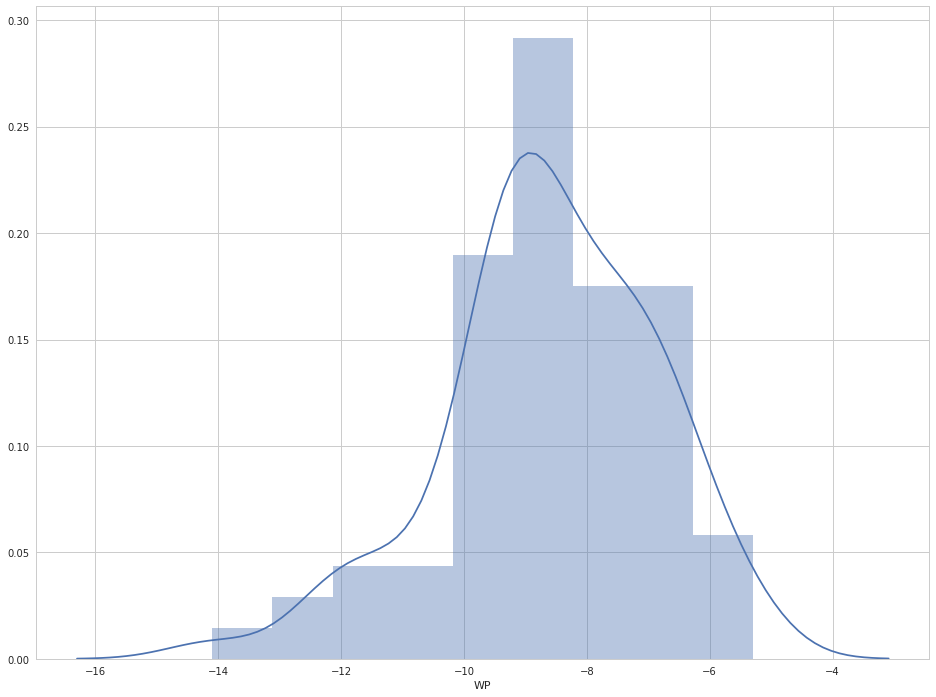

In [14]:
sns.distplot(df["WP"].dropna())

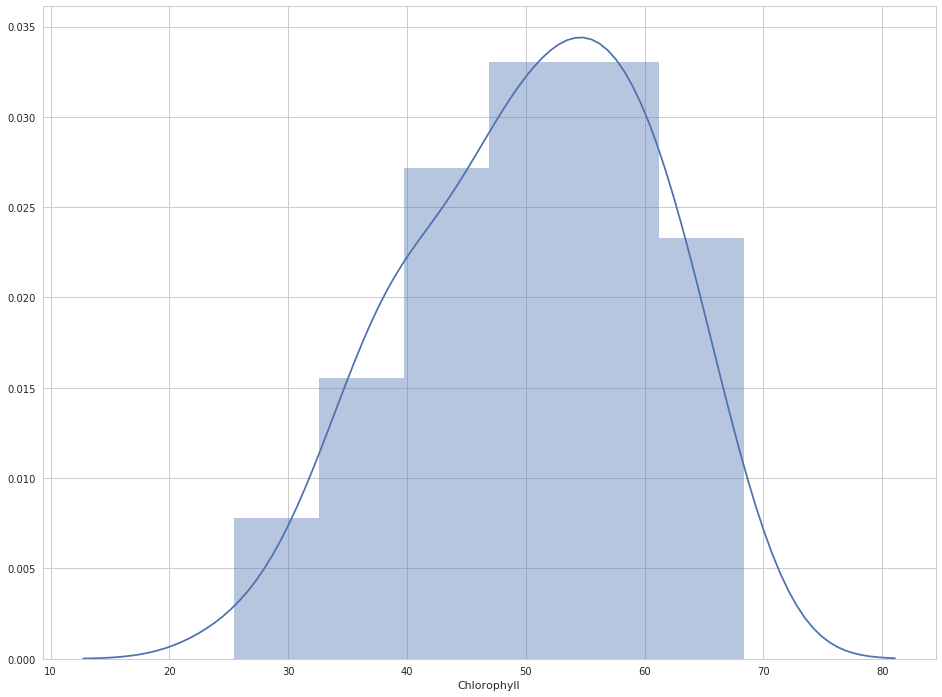

In [15]:
sns.distplot(df["Chlorophyll"].dropna())

## WP correlation with UAV indices

In [57]:
def create_scatter(x, y, x_title, y_title):
    fig = plt.figure()
    sns.regplot(x=x, y=y, fit_reg=False, label="big")
    plt.xlabel(x_title)
    plt.ylabel(y_title)

In [58]:
print("NDVI & WP:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["WP"])[0])
print("RedEdge & WP:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["WP"])[0])
print("EVI & WP:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["WP"])[0])
print("MCARI & WP:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["WP"])[0])
print("GNDVI & WP:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["WP"])[0])

NDVI & WP: 0.5423091743135346
RedEdge & WP: 0.481264386296515
EVI & WP: 0.48173770584122855
MCARI & WP: 0.5236964990339844
GNDVI & WP: 0.44390869459831694


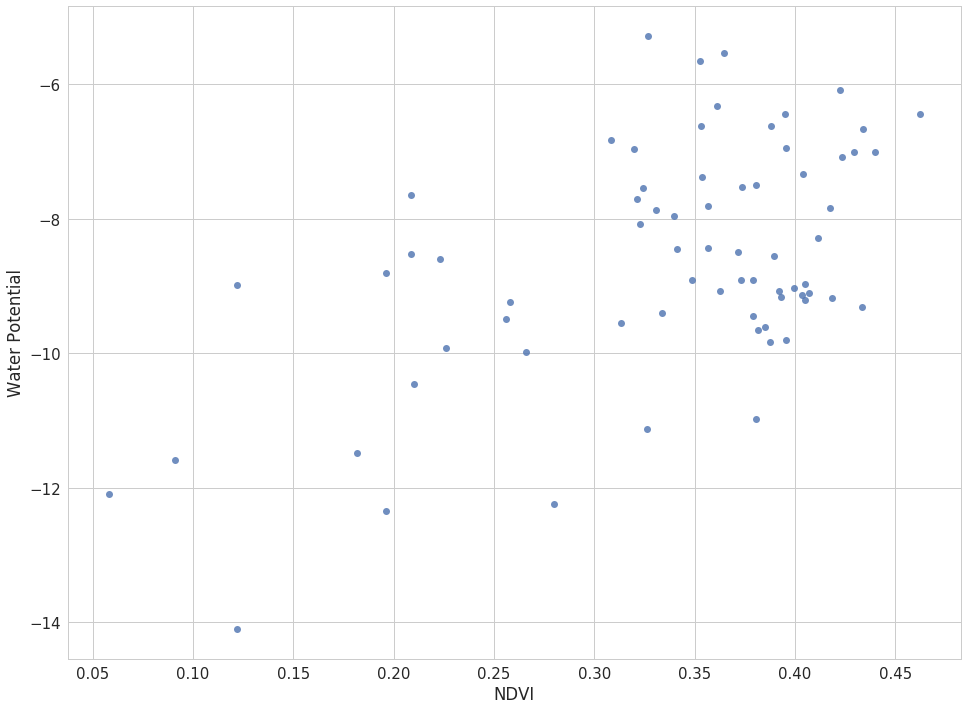

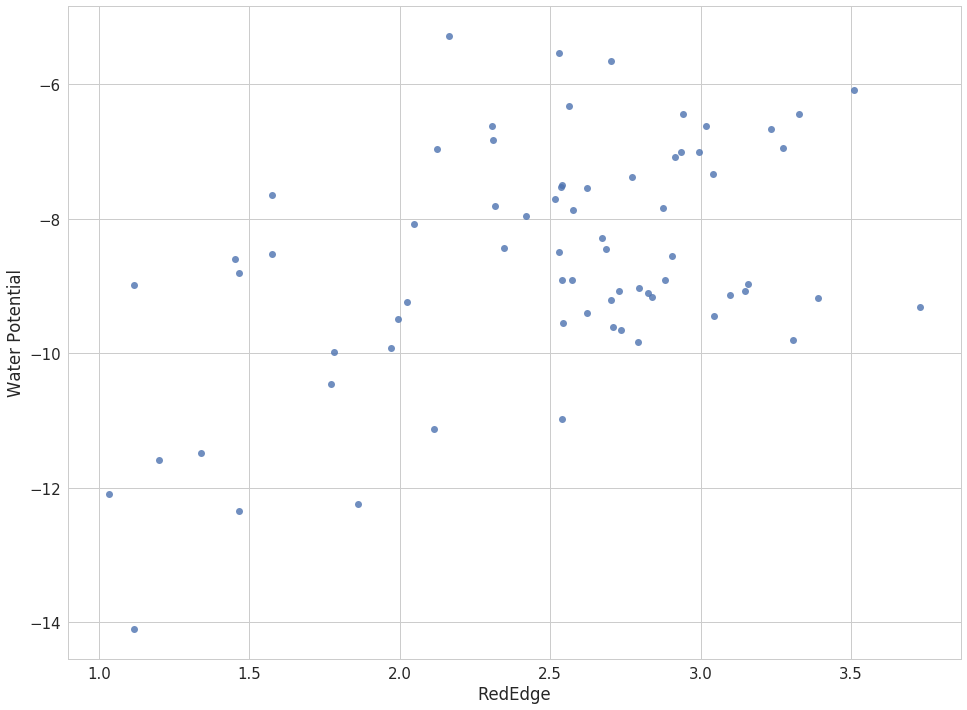

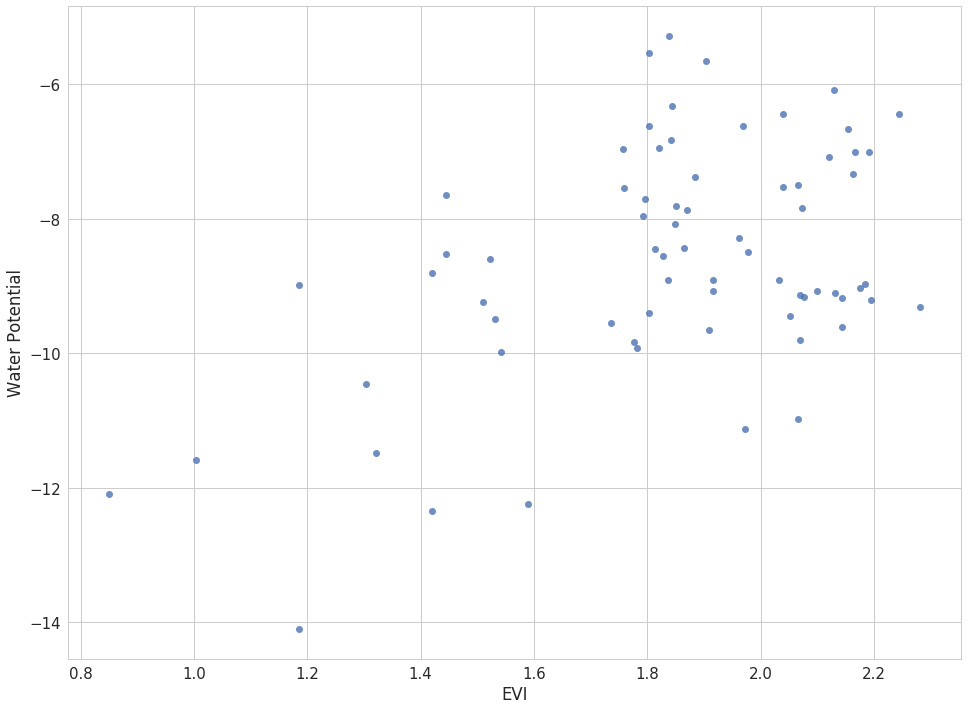

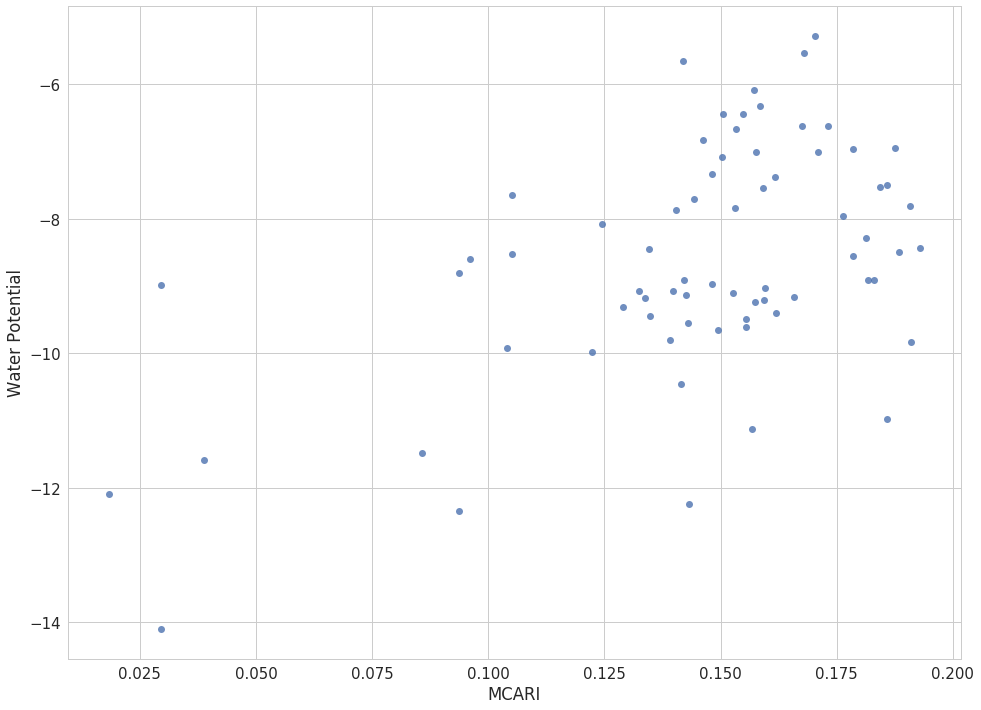

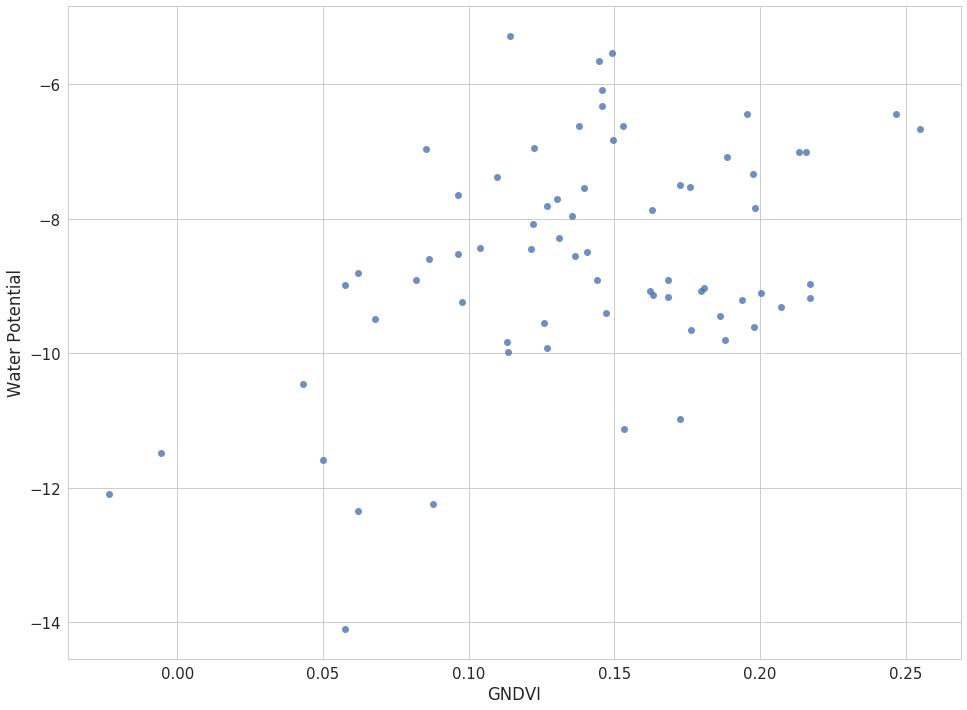

In [59]:
create_scatter(df["UAV_NDVI"], df["WP"], "NDVI", "Water Potential")
create_scatter(df["RedEdge"], df["WP"], "RedEdge", "Water Potential")
create_scatter(df["EVI"], df["WP"], "EVI", "Water Potential")
create_scatter(df["MCARI"], df["WP"], "MCARI", "Water Potential")
create_scatter(df["GNDVI"], df["WP"], "GNDVI", "Water Potential")

## Chlorophyll correlation with UAV indices

In [61]:
print("NDVI & Chlorophyll:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["Chlorophyll"])[0])
print("RedEdge & Chlorophyll:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["Chlorophyll"])[0])
print("EVI & Chlorophyll:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["Chlorophyll"])[0])
print("MCARI & Chlorophyll:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["Chlorophyll"])[0])
print("GNDVI & Chlorophyll:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["Chlorophyll"])[0])

NDVI & Chlorophyll: 0.4298743847269388
RedEdge & Chlorophyll: 0.5232128435504413
EVI & Chlorophyll: 0.3187913299515422
MCARI & Chlorophyll: 0.29913971208714785
GNDVI & Chlorophyll: 0.2697593743123432


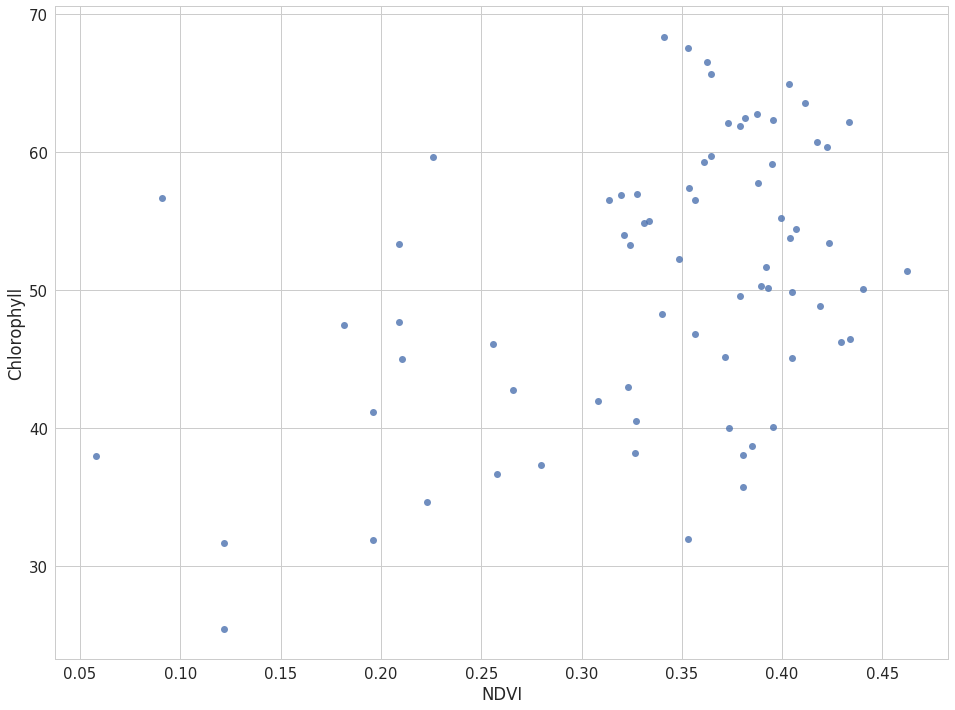

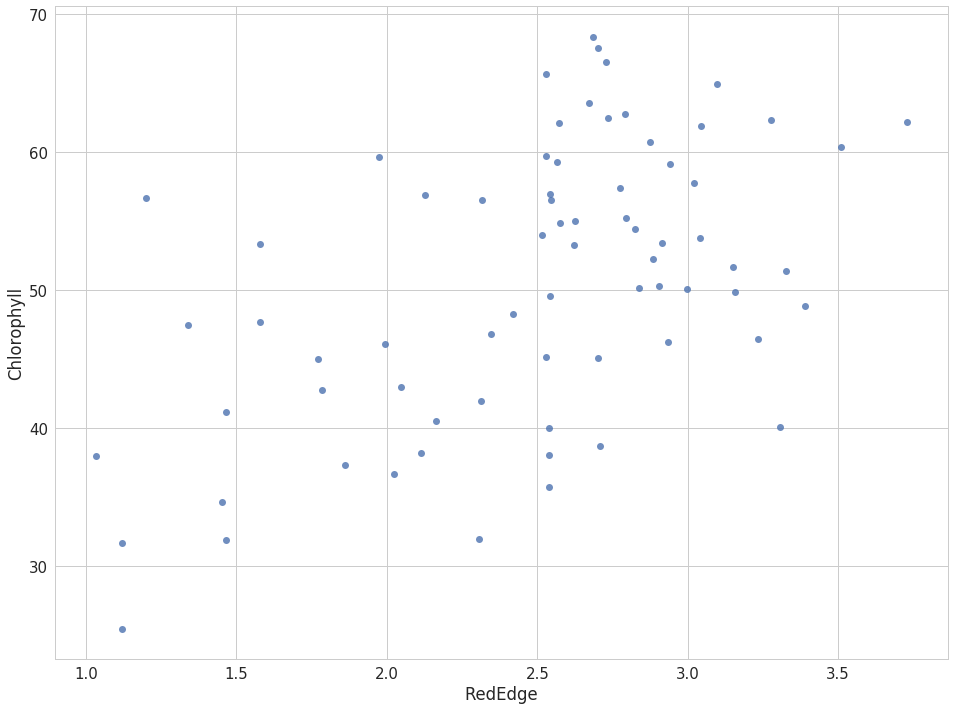

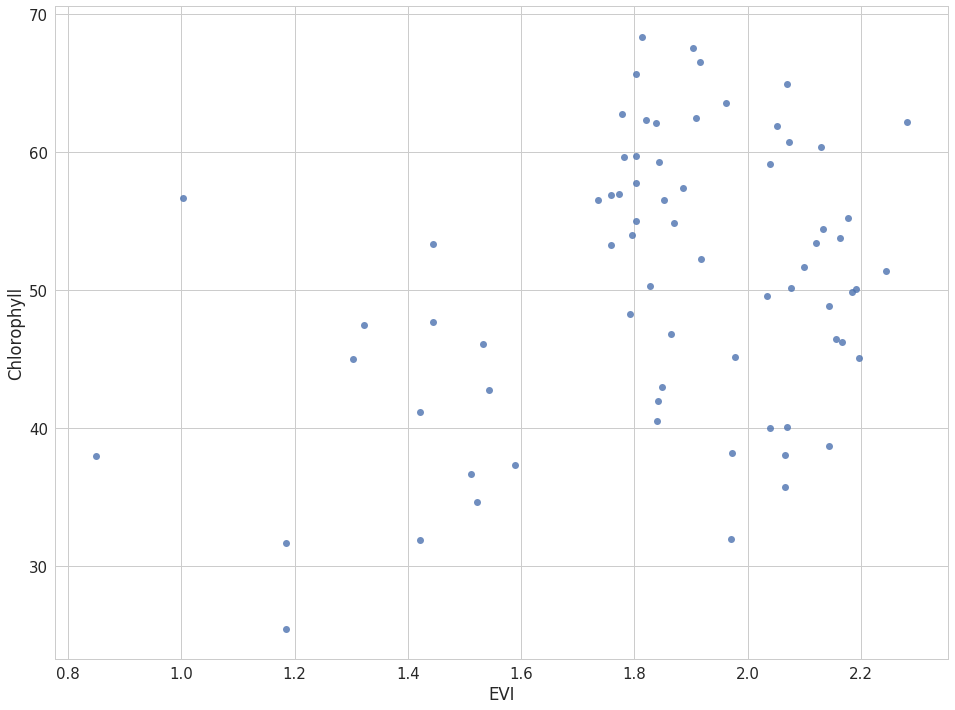

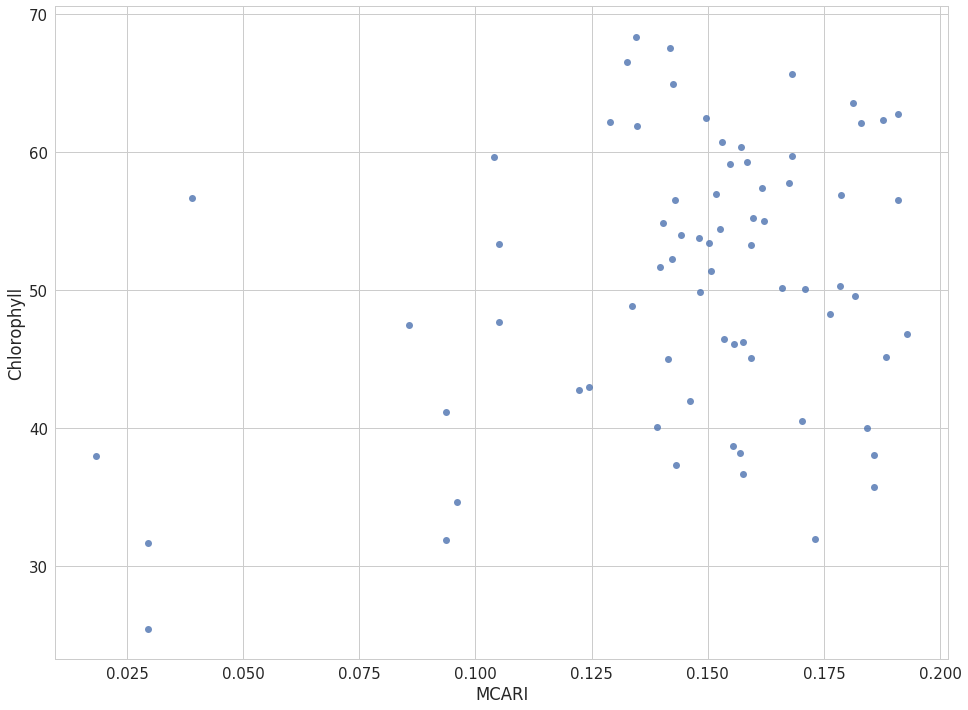

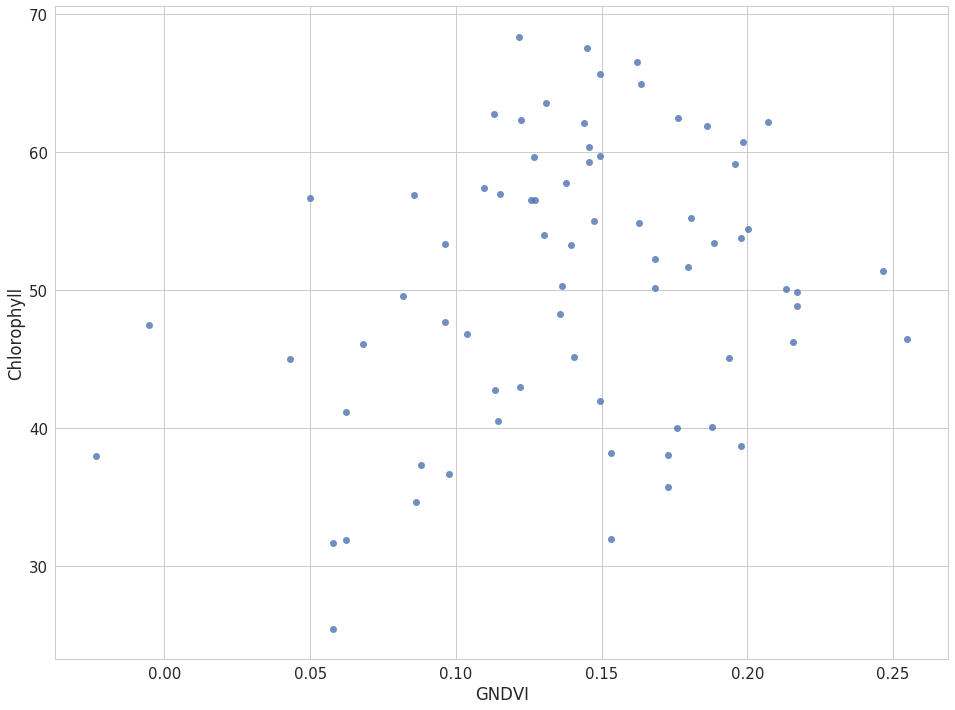

In [60]:
create_scatter(df["UAV_NDVI"], df["Chlorophyll"], "NDVI", "Chlorophyll")
create_scatter(df["RedEdge"], df["Chlorophyll"], "RedEdge", "Chlorophyll")
create_scatter(df["EVI"], df["Chlorophyll"], "EVI", "Chlorophyll")
create_scatter(df["MCARI"], df["Chlorophyll"], "MCARI", "Chlorophyll")
create_scatter(df["GNDVI"], df["Chlorophyll"], "GNDVI", "Chlorophyll")

## Learn index for WP

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [14]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

def normalize(xs):
    max_x = max(xs)
    min_x = min(xs)
    return [(x-min_x)/(max_x-min_x) for x in xs]

def standardize(xs):
    mu = np.mean(xs)
    sigma = np.std(xs)
    
    return [(x - mu) / sigma for x in xs]

In [21]:
X = np.array(list(df.dropna()["channel_vals"]))
y = np.array(normalize(list(df.dropna()["WP"])))

X, y = shuffle(X, y)

In [22]:
model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

RMSE: 0.17849366245507411
MAE: 0.15314643285710414
R2: 0.16002121521030255


Text(0,0.5,'Predicted WP')

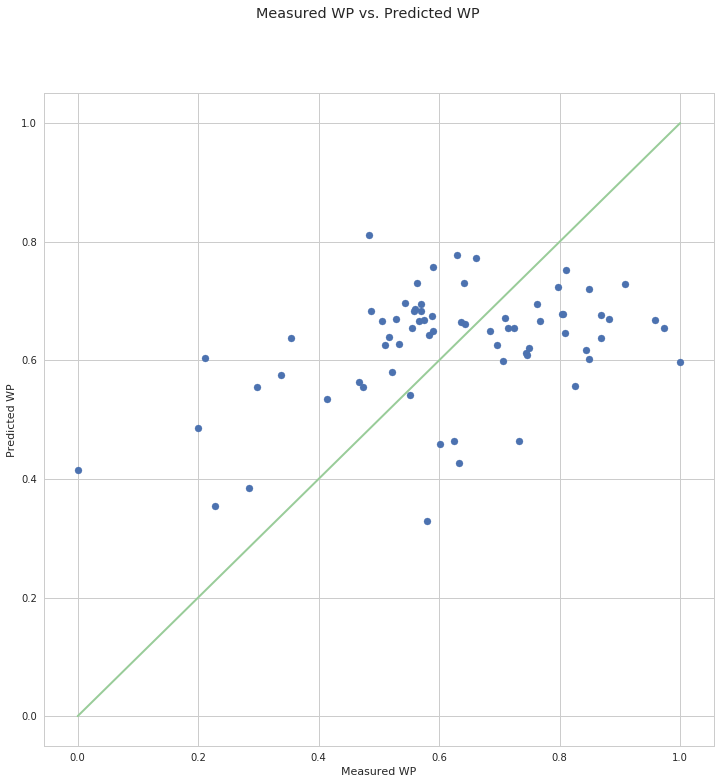

In [23]:
fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured WP vs. Predicted WP")
plt.xlabel("Measured WP")
plt.ylabel("Predicted WP")

## Learn index for chlorophyll

In [28]:
X = np.array(list(df["channel_vals"]))
y = np.array(normalize(list(df["Chlorophyll"])))

X, y = shuffle(X, y)

In [29]:
model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

RMSE: 0.1622539586051202
MAE: 0.1279422153190992
R2: 0.5114588754586951


Text(0,0.5,'Predicted Chlorophyll')

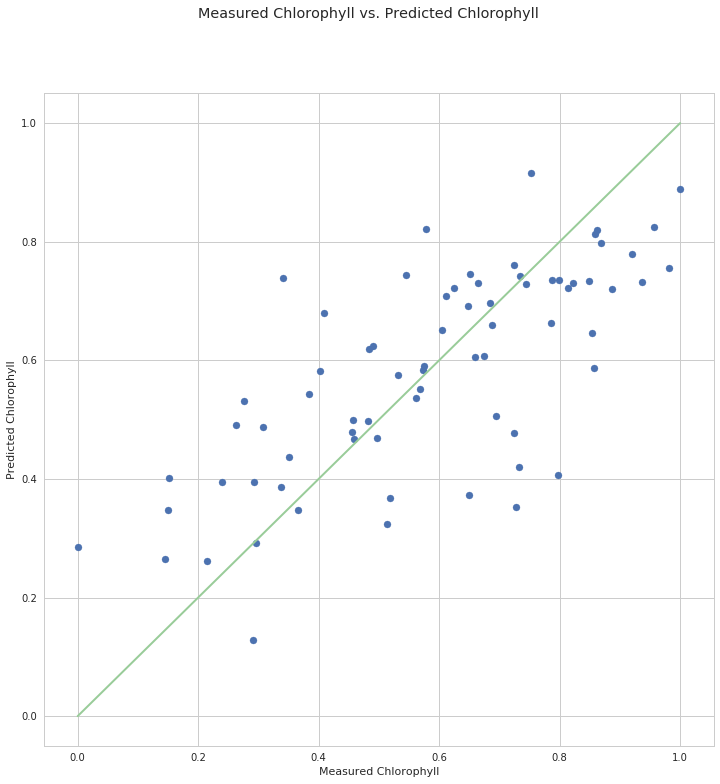

In [30]:
fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured Chlorophyll vs. Predicted Chlorophyll")
plt.xlabel("Measured Chlorophyll")
plt.ylabel("Predicted Chlorophyll")